# Analisis de grupo de whatsapp

En este proyecto analizaremos un grupo de whatsapp conformado por amigos. basado en el analisis hecho por "Saiteja Kura" que pueden encontrar [aqui](https://medium.com/towards-artificial-intelligence/whatsapp-group-chat-analysis-using-python-and-plotly-89bade2bc382) al que le realizamos unas modificaciones para que funcionara con nuestro archivo obtenido exportando la conversaciòn desde un android en idioma español.


In [1]:
###################################
##### CARGARMOS LAS LIBRERIAS #####
###################################
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from nltk.corpus import stopwords
%matplotlib inline

## Preparaciòn de los datos 

En esta primera parte tenemos que convertir nuestro archivo de texto de manera que la podamos guardar en un Pandas dataframe.

Vamos a considerar solo una linea del texto de nuestro archivo y ver como extraer columnas relevantes:

14/12/15 1:13 p. m. - Participante 1: Dos que tres leyeras simple

nuestro objetivo sera automaticamente separar la linea de texto en 4 tokens.

{Fecha} {Hora} - {Autor}: {Mensaje}

{14/12/15} {1:13 p. m.} - {Participante 1}: {Dos que tres leyeras simple}


In [2]:
# Funcion para determinar si una linea comienza con fecha y hora
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+) ([0-9]+):([0-9]+)[ ]?(a.\sm.|p.\sm.)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
lineEx = '14/12/15 1:13 p. m. - Participante 1: Dos que tres leyeras simple'
lineEx = lineEx.replace(u'\xa0', u' ')
startsWithDateAndTime(lineEx)

# Funcion para obtener la fecha y la hora un string de esta forma ( 14/12/15 1:13 p. m. )
def getDateTime(dateTimeString):
    timeS = re.search(r'([0-9]+):([0-9]+)[ ]?(a.\sm.|p.\sm.)?', dateTimeString)
    dateS = re.search(r'^([0-9]+)(\/)([0-9]+)(\/)([0-9]+)', dateTimeString)
    return dateS.group(0) if dateS else dateS,timeS.group(0) if timeS else timeS

dateTime = lineEx.split('-')[0]
print(getDateTime(dateTime))

('14/12/15', '1:13 p. m.')


In [4]:
# Econtrar en autor del mensaje
def FindAuthor(s):
  s=s.split(":")
  if len(s)>=2:
    return True
  else:
    return False

In [5]:
# obtener los tokens por linea
def getDataPoint(line):
    line = line.replace(u'\xa0', u' ')
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date, time = getDateTime(dateTime)
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [73]:
parsedData = [] # Lista para guardar los datos para ser usada por el Pandas dataframe
conversationPath = 'Chat de WhatsApp con Grupo amistoso.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # omitimos la primera linea porque contiene informacion acerca de la creacion del grupo
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [74]:
# creamos el dataframes de panda con las de fecha, hora, autor y mensaje
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Inicializamos el pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df['Message'] = df['Message'].str.lower() # convertimos todo el mensaje a minúsculas
df['Message'] = df.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja") # Estadarizacion de las risas a "jaja"
df['Message'] = df.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja") # Estadarizacion de las risas a "jaja"
df['Message'] = df.Message.str.replace(r"(a|h)?(ha)+(a|h)?", "jaja") # Estadarizacion de las risas a "jaja"

In [75]:
# descripcion del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3358 entries, 0 to 3357
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     3358 non-null   datetime64[ns]
 1   Time     3358 non-null   object        
 2   Author   3323 non-null   object        
 3   Message  3358 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 105.1+ KB


## Imprimiendo participantes

Como vemos en los autores podemos llegar tener un valor None que serian las lineas que no tienen autor como:
* participante 1 cambió el asunto a "nuevo asunto"
* participante 1 cambió el icono de este grupo
* participante 1 añadio
* etc.

vamos a eliminar estos mensajes creados por "None"

In [76]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3323 entries, 0 to 3354
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     3323 non-null   datetime64[ns]
 1   Time     3323 non-null   object        
 2   Author   3323 non-null   object        
 3   Message  3323 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 129.8+ KB


In [77]:
# Anonimizar los datos
# Lista con los personajes del Señor de los Anillos
got_dt = pd.read_csv("https://raw.githubusercontent.com/tmdavid/lotr-names-classification/master/characters_no_surnames.csv") 

# Obtiene nombres y aliases
nombres = list(df.Author.unique())
aliases = list(got_dt.name.sample(len(nombres)))

df.Author.replace(nombres, aliases, inplace=True) # Remplaza en la reemplaza los autores de los mensajes por aliases por entrada completa

df.Author.unique()

array(['Handir', 'Chica', 'Holfast', 'Brand', 'Ruby', 'Meriadoc', 'Bór',
       'Tarannon', 'Bard', 'Galdor', 'Andreth', 'Glorfindel', 'Wilcome',
       'Isilmë', 'Grór'], dtype=object)

Volvemos a imprimir los autores para validar y listo ya no tenemos al autor None

## Estadisticas de grupo


In [78]:
total_messages = df.shape[0]
print("Total de mensajes : {} ".format(total_messages))

media_messages = df[df.Message == '<multimedia omitido>'].shape[0]
print("Total de mensaje multimedia : {}".format(media_messages))

Total de mensajes : 3323 
Total de mensaje multimedia : 524


In [79]:
# Funcion para encontrar los emojis en el mensaje y separarlos en una lista
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)
df[df.emoji.str.len() > 0]

Date        Time    Author  \
8    2015-12-14  1:14 p. m.   Holfast   
9    2015-12-14  1:14 p. m.    Handir   
10   2015-12-14  1:14 p. m.     Chica   
14   2015-12-14  1:16 p. m.      Ruby   
16   2015-12-14  1:16 p. m.     Brand   
...         ...         ...       ...   
3302 2017-10-21  2:54 p. m.    Galdor   
3304 2017-10-21  2:56 p. m.      Bard   
3306 2017-10-21  3:19 p. m.    Galdor   
3319 2018-03-29  1:16 p. m.  Meriadoc   
3337 2018-06-15  4:31 p. m.   Holfast   

                                                Message                 emoji  
8                                                    ☝🏼                  [☝🏼]  
9                                                    ☝🏿                  [☝🏿]  
10                                                   🙋🏿                  [🙋🏿]  
14                                                 👉🏼👌🏽              [👉🏼, 👌🏽]  
16                                           ✋🏼✋🏼✋🏼✋🏼✋🏼  [✋🏼, ✋🏼, ✋🏼, ✋🏼, ✋🏼]  
...                                                 ...                   ...  
3302                                               👌🏿👍🏿              [👌🏿, 👍🏿]  
3304  le recomiendo los cantineros osea chile de árb...                  [👌🏼]  
3306                                 de todo un poco 👌🏿                  [👌🏿]  
3319                                              😂😂😂😂😂       [😂, 😂, 😂, 😂, 😂]  
3337                                                 🤔🤔                [🤔, 🤔]  

[552 rows x 5 columns]

In [80]:
# obtener el total de emojis
emojis = sum(df['emoji'].str.len())
print(emojis)

1142


In [81]:
# Obtenemos los mensajes que contengan una link
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [82]:
print("Estadisticas del grupo")
print("Mensajes:",total_messages)
print("Multimedia:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Estadisticas del grupo
Mensajes: 3323
Multimedia: 524
Emojis: 1142
Links: 9


### Vamos a separar los mensajes multimedia

In [83]:
media_messages_df = df[df.Message == '<multimedia omitido>']
messages_df = df.drop(media_messages_df.index)

In [84]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2799 entries, 0 to 3354
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2799 non-null   datetime64[ns]
 1   Time      2799 non-null   object        
 2   Author    2799 non-null   object        
 3   Message   2799 non-null   object        
 4   emoji     2799 non-null   object        
 5   urlcount  2799 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 153.1+ KB


In [85]:
# Agregamos dos columnas a nuestro messages_df para contar
# el numero de letras de un mensaje y el numero de palabras
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [86]:
messages_df.head()

Date        Time  Author                      Message emoji  urlcount  \
0 2015-12-14  1:12 p. m.  Handir            perrequetengue es    []         0   
1 2015-12-14  1:12 p. m.  Handir                           ae    []         0   
2 2015-12-14  1:12 p. m.  Handir                         jaja    []         0   
3 2015-12-14  1:13 p. m.   Chica                         jaja    []         0   
4 2015-12-14  1:13 p. m.   Chica  dos que tres leyeras simple    []         0   

   Letter_Count  Word_Count  
0            17           2  
1             2           1  
2             4           1  
3             4           1  
4            27           5

In [87]:
# agregamos una nueva columna contando el total de emojis
messages_df["emojicount"]= df['emoji'].str.len()

## Estadìsticas del autor

In [88]:
# Creamos una lista de los autores
l = messages_df.Author.unique()

for i in range(len(l)):
    # Filtramos los mensajes de un autor en particular
    req_df= messages_df[messages_df["Author"] == l[i]]
    # req_df solo contendra mensajes de un solo autor
    print(f'Estadìsticas de \033[1m{l[i]}\033[0m ')
    # shape imprimira el numero de renglones que significan indirectamente el numero de mensajess
    print('Mensajes enviados: ', req_df.shape[0])
    # Word_Count contiene el total de palabras por mensaje. 
    # Total de palabras / Total Mensajes nos da el nùmero de palabras por mensaje
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Palabras por mensaje: ', words_per_message)
    # Mensajes multimedia enviados
    media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
    print('Mensajes multimedia enviados: ', media)
    # Total emojis enviados
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis enviados: ', emojis)
    # Total de links enviados
    links = sum(req_df["urlcount"])   
    print('Links enviados', links)   
    print()

Estadìsticas de Handir 
Mensajes enviados:  471
Palabras por mensaje:  3.0573248407643314
Mensajes multimedia enviados:  44
Emojis enviados:  278
Links enviados 1

Estadìsticas de Chica 
Mensajes enviados:  263
Palabras por mensaje:  4.562737642585551
Mensajes multimedia enviados:  47
Emojis enviados:  96
Links enviados 1

Estadìsticas de Holfast 
Mensajes enviados:  304
Palabras por mensaje:  3.8815789473684212
Mensajes multimedia enviados:  22
Emojis enviados:  153
Links enviados 1

Estadìsticas de Brand 
Mensajes enviados:  119
Palabras por mensaje:  4.19327731092437
Mensajes multimedia enviados:  7
Emojis enviados:  79
Links enviados 0

Estadìsticas de Ruby 
Mensajes enviados:  101
Palabras por mensaje:  4.297029702970297
Mensajes multimedia enviados:  19
Emojis enviados:  40
Links enviados 0

Estadìsticas de Meriadoc 
Mensajes enviados:  231
Palabras por mensaje:  3.761904761904762
Mensajes multimedia enviados:  12
Emojis enviados:  68
Links enviados 0

Estadìsticas de Bór 
Mensaj

## Estadísticas de emojis

### Emojis diferentes

In [89]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(f"total de emojis diferentes: {total_emojis}")

total de emojis diferentes: 194


### Emoji mas usado

In [90]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 309), ('😆', 63), ('🖕🏿', 53), ('🖕', 35), ('☁', 31), ('😭', 26), ('😁', 25), ('🤔', 17), ('🙄', 17), ('🙊', 15), ('😱', 14), ('❤', 13), ('👀', 12), ('🎤', 12), ('🖕🏼', 12), ('😷', 12), ('💰', 12), ('😘', 12), ('💔', 11), ('😍', 11), ('🙈', 11), ('💨', 10), ('👌🏿', 10), ('✊🏼', 8), ('👌🏼', 7), ('😒', 6), ('🍸', 6), ('☺', 6), ('😎', 6), ('👍🏼', 6), ('🎉', 6), ('👌', 6), ('☝🏼', 5), ('👉🏼', 5), ('✋🏼', 5), ('💩', 5), ('😄', 5), ('💅🏼', 5), ('😏', 5), ('😢', 5), ('🍺', 5), ('🙂', 5), ('👌🏽', 4), ('💁🏽', 4), ('👆🏼', 4), ('😀', 4), ('🙅🏿', 4), ('📣', 4), ('😣', 4), ('💪🏻', 4), ('👌🏻', 4), ('😈', 4), ('☕', 4), ('🍷', 4), ('😪', 4), ('😴', 4), ('☹', 4), ('👏🏿', 4), ('👍🏿', 4), ('👏🏼', 4), ('😲', 4), ('🙋🏿', 3), ('😞', 3), ('😳', 3), ('💁🏻', 3), ('💸', 3), ('🚍', 3), ('🚌', 3), ('👍', 3), ('😬', 3), ('💃🏽', 3), ('💃🏻', 3), ('😓', 3), ('🤗', 3), ('😐', 3), ('🎊', 3), ('❗', 3), ('🐷', 3), ('🐖', 3), ('🍻', 3), ('😜', 3), ('🌚', 3), ('🙏🏽', 3), ('👅', 3), ('🤣', 3), ('🤙🏼', 3), ('☝🏿', 2), ('🔫', 2), ('👾', 2), ('🎶', 2), ('🎁', 2), ('😔', 2), ('🚶🏻', 2), ('😉', 2), ('🐒', 2)

In [91]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

emoji  count
0       😂    309
1       😆     63
2      🖕🏿     53
3       🖕     35
4       ☁     31
..    ...    ...
189     🎩      1
190  🤦🏻‍♂      1
191     🌶      1
192    ☝🏻      1
193  🤷🏻‍♂      1

[194 rows x 2 columns]

In [92]:
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Distrbuciòn de emojis por persona

In [93]:
# Creamos de nuevo las lista de autores 
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print(f'Distribuciòn de emojis para \033[1m{l[i]}\033[0m')
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Distribuciòn de emojis para Handir


Distribuciòn de emojis para Chica


Distribuciòn de emojis para Holfast


Distribuciòn de emojis para Brand


Distribuciòn de emojis para Ruby


Distribuciòn de emojis para Meriadoc


Distribuciòn de emojis para Bór


Distribuciòn de emojis para Tarannon


Distribuciòn de emojis para Bard


Distribuciòn de emojis para Galdor


Distribuciòn de emojis para Andreth


Distribuciòn de emojis para Glorfindel


Distribuciòn de emojis para Wilcome


Distribuciòn de emojis para Isilmë


Distribuciòn de emojis para Grór


## Mas estadìsticas

### distribuciòn de mensajes por dia de la semana

para el caso de este grupo vecinal vemos que es un poco extraña la distribuciòn de los dias con mas mensajes
siendo abarcando de sabado a martes.

In [94]:
def f(i):
  l = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sàbado", "Domingo"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [95]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
        range=[0,600]
    )),
  showlegend=False
)
fig.show()

In [96]:
messages_df['MessageCount'] = 1
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount",title='Nùmero de mensajes a travès del tiempo', labels={"MessageCount":"Total mensajes","Date":"Fecha"})
fig.update_xaxes(nticks=20)
fig.show()

In [97]:
# sacamos un promedio del total de mensajes con un ventana de 30 dias 
date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

In [98]:
# Grafico mensajes por autor
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
auth.sort_values(by=['MessageCount'],ascending=False,inplace=True)
fig = px.bar(auth, y="MessageCount", x="Author", title="Mensajes por autor")
fig.show()

### Actividad del grupo 

##### Actividad diaria por horas
Como vemos en la grafica siguiente por ser un grupo de jovenes aun estudiando las horas con mas movimiento es por las noches y a la hora comun de salida de la escuela

Text(0, 0.5, 'Hora')

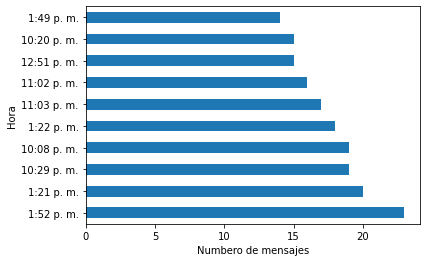

In [99]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 horas del dia con mas nùmero de mensajes enviados
plt.xlabel('Numbero de mensajes')
plt.ylabel('Hora')

#### Dias con mas movimiento

En este caso vemos que el dia con mas mensajes fue el dia de la creación del grupo

Text(0, 0.5, 'Fecha')

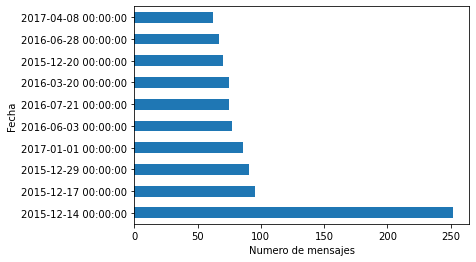

In [100]:
# Top 10 dias con mas mensajes
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Numero de mensajes')
plt.ylabel('Fecha')

## Nube de palabras

In [101]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
print(text)

There are 58155 words in all the messages.
perrequetengue es ae jaja jaja dos que tres leyeras simple letras* bueno mucjajachos este grupo es con el fin de checar su asistencia a nuestra pacjajanga de año nuevo así que los que van a asistir levanten la mano ☝🏼 ☝🏿 🙋🏿 va el dia prinero esta juntada? el 31 jajaaa en donde sera 👉🏼👌🏽 jajay en la recidencial ✋🏼✋🏼✋🏼✋🏼✋🏼 💁🏽 por la calle principal jajay sorry es este👆🏼 jaja jaja tons ya sabes 300 por chompa 👙 💩 👠 oigan ya no jajay que poner tanta pendejajada jaja 👀 es serio esto por si entra un contrario en caliente lo tumban 🎤 jaja jaja el dinero tiene que estar antes del 24 👆🏼 con el dinero que se jajara??? y digan quien quiere ser recolector de dinero junto conmigo para que todo sea legal también su 45 conmemorativa con el tiro arriba🎤🔫 con tickets y todo jaja yo se los recolecto jaja yo recolectó 🙋🏿 me apunto como tesorero jaja 🎮👾 jajana 👰🏿 me va a amanecer un etsbots nmms jaja y tambien digan de que botellas quieren miren el otro domingo e

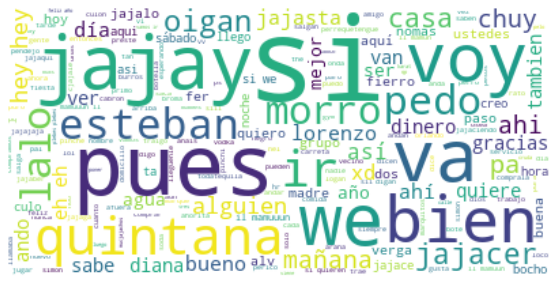

In [102]:
# creamos un set de las palabras de paro para omitirlas en nuestra nube de palabras
stopwordsSet = set(stopwords.words('spanish'))
# agregamos mas stopwords a las palabras de paro
stopwordsSet.update([ "jaja"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwordsSet, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Nube de palabras por autor



Nube de Handir


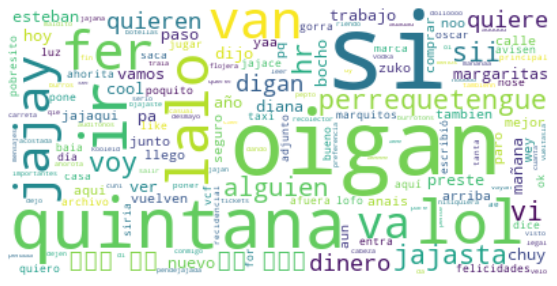

Nube de Chica


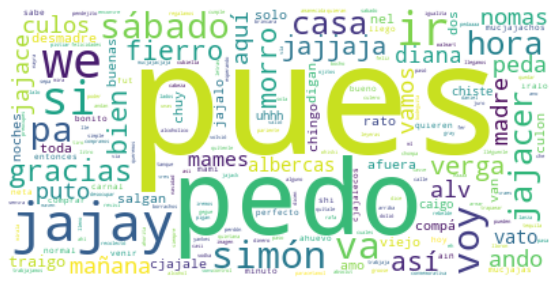

Nube de Holfast


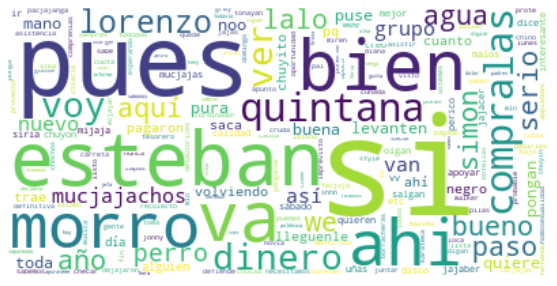

Nube de Brand


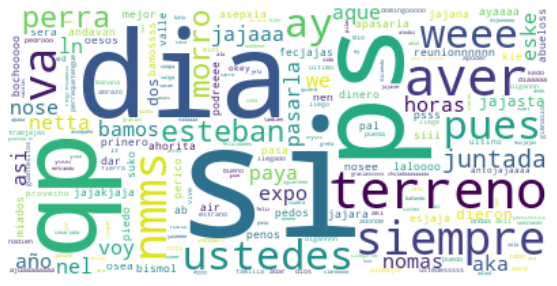

Nube de Ruby


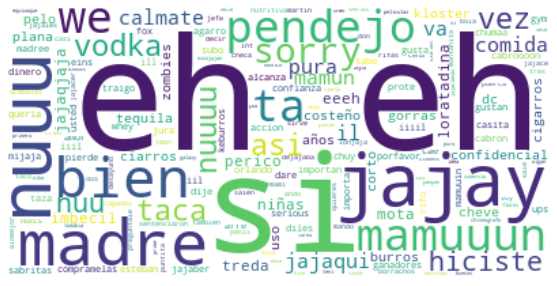

Nube de Meriadoc


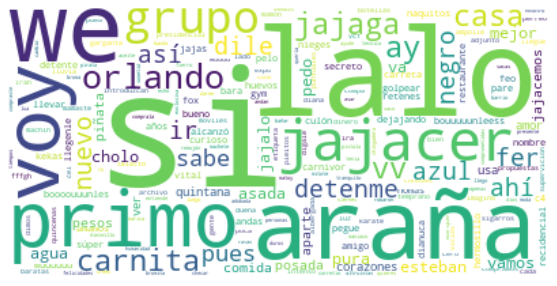

Nube de Bór


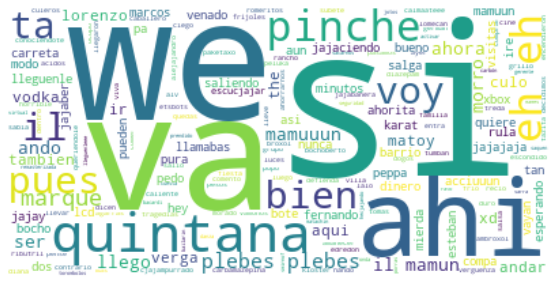

Nube de Tarannon


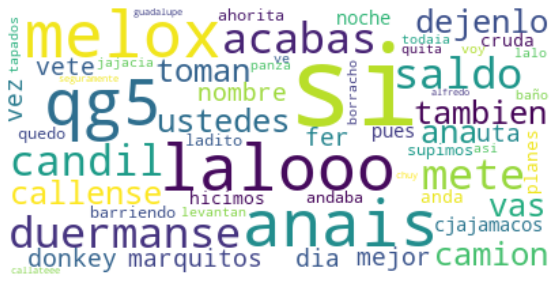

Nube de Bard


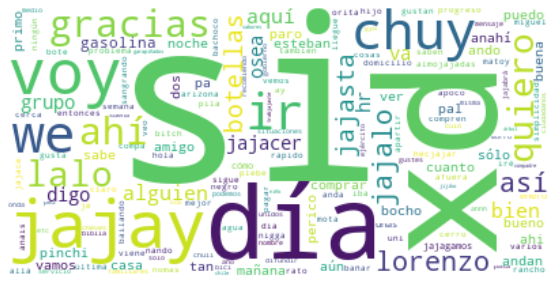

Nube de Galdor


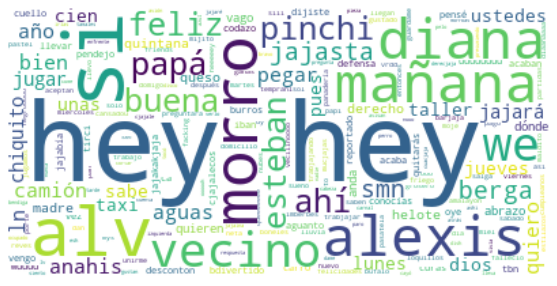

Nube de Andreth


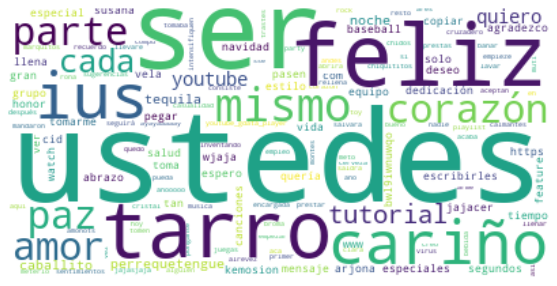

Nube de Glorfindel


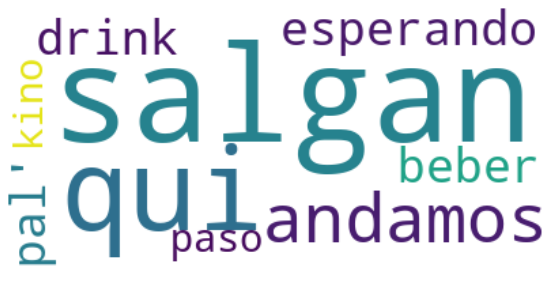

Nube de Wilcome


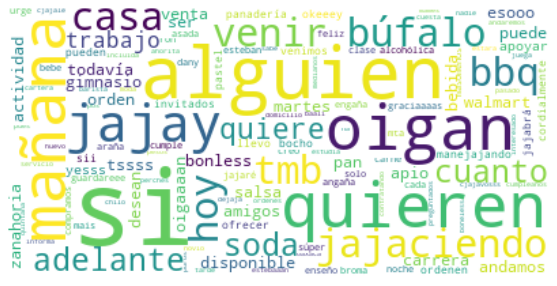

Nube de Isilmë


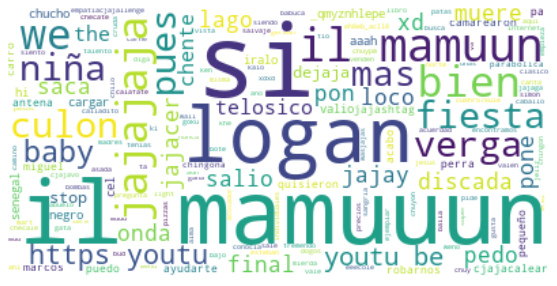

Nube de Grór


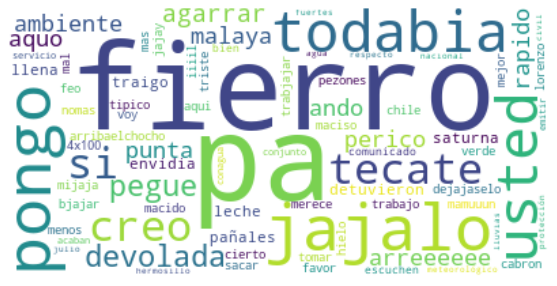

In [103]:
l = messages_df.Author.unique()
for i in range(len(l)):
    dummy_df = messages_df[messages_df.Author == l[i]]
    textA = " ".join(review for review in dummy_df.Message)
    print(f'Nube de \033[1m{l[i]}\033[0m')
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwordsSet, background_color="white").generate(textA)
    # Display the generated image:
    # the matplotlib way:
    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    